# Libraries

In [59]:
# default libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import math
from scipy.stats import norm
from sklearn.linear_model import LinearRegression

In [2]:
# plotting configuration
sns.set(style = 'darkgrid',
        font_scale = 1.4,
        rc = {"lines.linewidth": 2,
          "figure.figsize": (12, 8)})

sns.set_palette('Set2')

In [21]:
from tools import get_exponential_bins, compute_quantile_hist_data, compute_interval_score
from data_gen import generate_raw_data,get_binned_data_cookie_bucket_level
from hyp_tests import percentile_bootstrap_ci_ratio_cookie_buckets
from hyp_tests import bc_a_bootstrap_ratio_cookie_buckets
from hyp_tests import jackknife_cookie_bucket_quantile_bucketed
from data_gen import generate_raw_data_lognormal
from data_gen import generate_raw_data_exponential
from data_gen import generate_data_mixture_exp_bucket_level
from data_gen import generate_data_single_corrupted_exp_bucket_level
from hyp_tests import compute_pseudovals_jackknife

# Simulations

## Exponential case

### Moderate data regime

In [165]:
bins_boundaries= get_exponential_bins(10,600000,100)

In [166]:
cand_num_of_cookie_buckets = np.arange(10,110,step=10).tolist()

In [167]:
raw_data_treatment = generate_raw_data_exponential(number_of_users = 1000, scale_param=500)
raw_data_control = generate_raw_data_exponential(number_of_users = 1000, scale_param=500)

In [168]:
number_of_inner_boot_samples = 200
number_of_outer_boot_samples = 200

In [169]:
orig_jack_est = list()
boot_jack_est_50 = list()
boot_jack_stds_50 = list()

In [170]:
for cookie_bucket in cand_num_of_cookie_buckets:
    boot_jack_est_50 +=[[]]
    boot_jack_stds_50 +=[[]]

In [171]:
cur_quantile_of_interest = 0.5

for cur_ind, cur_num_of_cookie_buckets in enumerate(cand_num_of_cookie_buckets):
    # bin raw data and place the clients into cookie buckets
    bucketed_data_treat = get_binned_data_cookie_bucket_level(raw_data_treatment, cur_num_of_cookie_buckets, bins_boundaries).values
    bucketed_data_control = get_binned_data_cookie_bucket_level(raw_data_control, cur_num_of_cookie_buckets, bins_boundaries).values

    orig_jack_est +=[np.mean(compute_pseudovals_jackknife(bucketed_data_treat, bucketed_data_control,
        bins_boundaries, cur_quantile_of_interest))]

    # possible indices to perform resamplaing
    indices = np.arange(cur_num_of_cookie_buckets)

    for i in range(number_of_outer_boot_samples):
        ind_resampled = np.random.choice(
                indices, size = cur_num_of_cookie_buckets)

        boot_treat = bucketed_data_treat[ind_resampled, :]
        boot_control = bucketed_data_control[ind_resampled, :]

        #compute pseudo-values
        pseudo_vals = compute_pseudovals_jackknife(boot_treat, boot_control, bins_boundaries, cur_quantile_of_interest)

        # compute the mean / jackknife estimator
        boot_jack_est_50[cur_ind] += [np.mean(pseudo_vals)]

        #estimate standard error of this estimator
        inner_est = list()

        for j in range(number_of_inner_boot_samples):
            ind_resampled_inner = np.random.choice(
                indices, size = cur_num_of_cookie_buckets)
            boot_treat_inner = boot_treat[ind_resampled_inner, :]
            boot_control_inner = boot_control[ind_resampled_inner, :]
            cur_psvals =compute_pseudovals_jackknife(boot_treat_inner,boot_control_inner,bins_boundaries,cur_quantile_of_interest) 
            inner_est+=[np.mean(cur_psvals)]

        boot_jack_stds_50[cur_ind]+=[np.std(inner_est, ddof=1)]

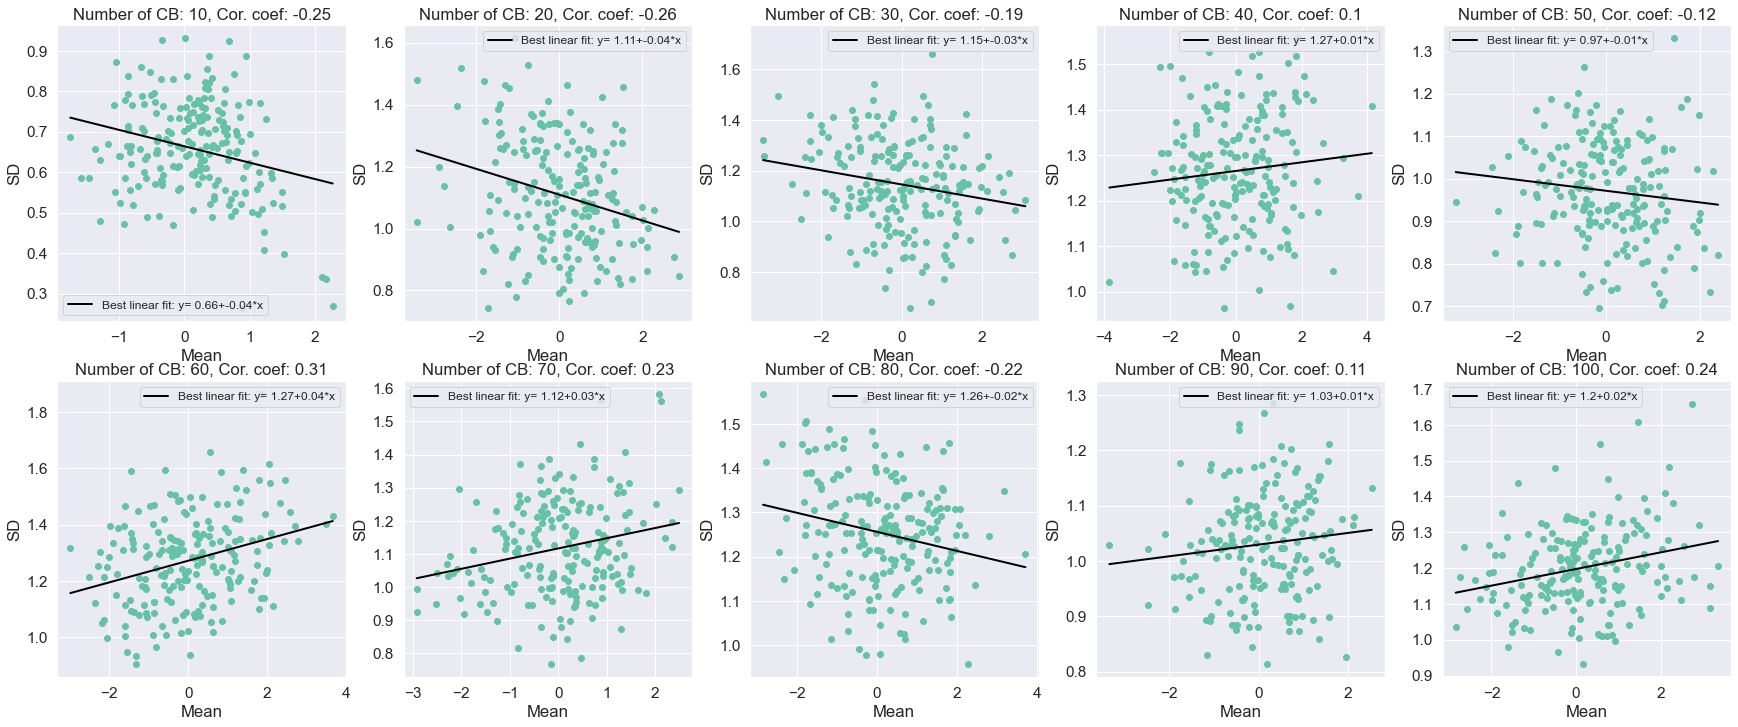

In [172]:
plt.figure(figsize=[30,12])
for i, cur_number_of_buckets in enumerate(cand_num_of_cookie_buckets):
    plt.subplot(2, 5, i+1).set_title('Number of CB: ' + str(cur_number_of_buckets)+', Cor. coef: '+ str(np.corrcoef(boot_jack_est_50[i],boot_jack_stds_50[i])[1,0].round(2)))
    
    cur_boot_est = np.array(boot_jack_est_50[i])
    cur_boot_stds= np.array(boot_jack_stds_50[i])
    
    plt.scatter(cur_boot_est,cur_boot_stds)
    
    reg_1 = LinearRegression().fit(cur_boot_est.reshape(-1,1),cur_boot_stds)
    x_range = np.linspace(min(cur_boot_est), max(cur_boot_est))
    
    plt.plot(x_range ,reg_1.intercept_ + reg_1.coef_ * x_range, color='black', label='Best linear fit: y= ' + 
    str(reg_1.intercept_.round(2)) +'+' +str(reg_1.coef_.round(2)[0])+"*x")
    
    plt.legend(prop={'size': 12})
    plt.xlabel('Mean')
    plt.ylabel('SD')


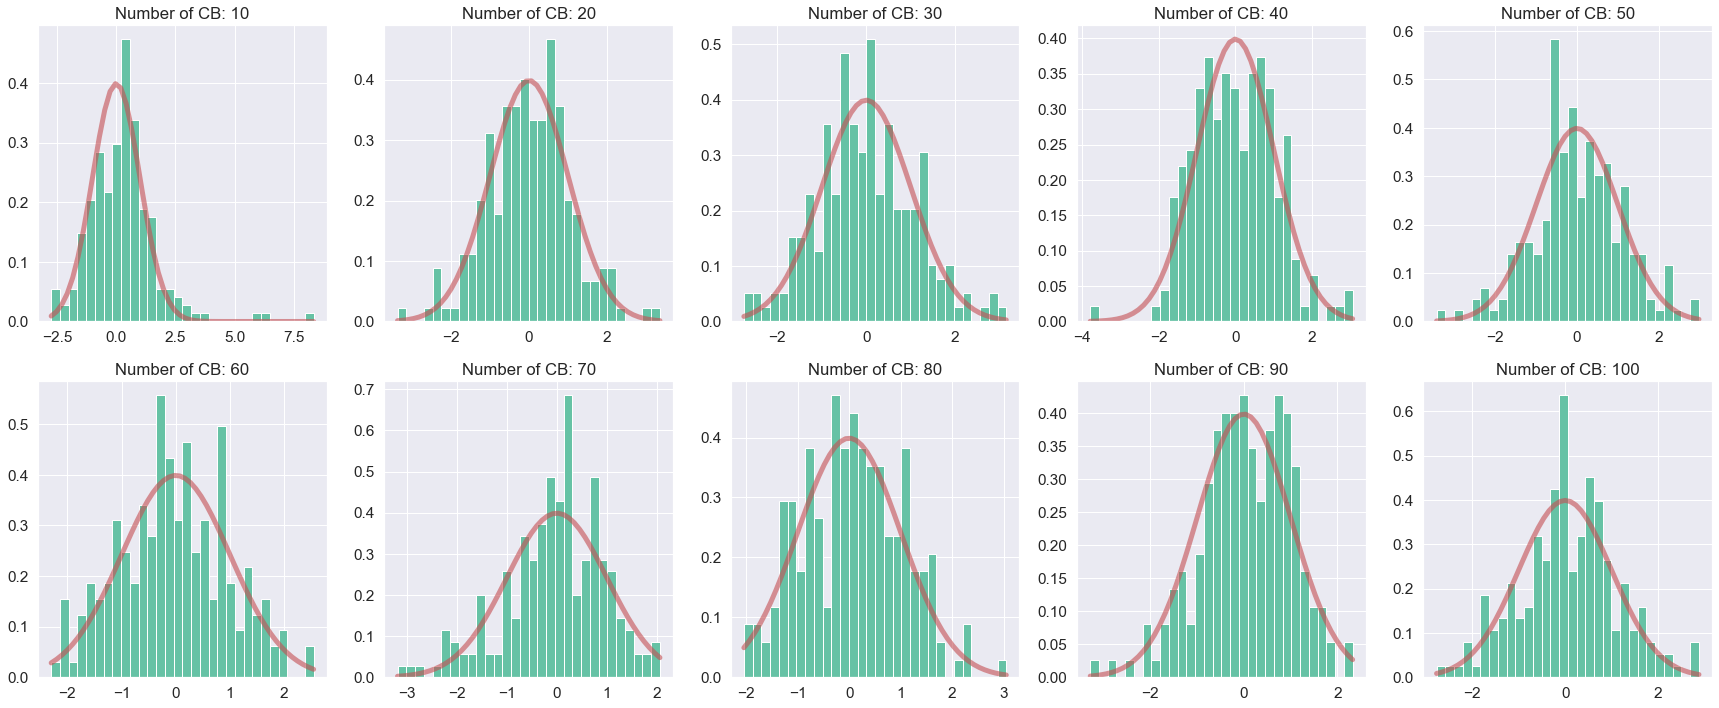

In [174]:
plt.figure(figsize=[30,12])
for i, cur_number_of_buckets in enumerate(cand_num_of_cookie_buckets):
    plt.subplot(2, 5, i+1).set_title('Number of CB: ' + str(cur_number_of_buckets))
    cur_boot_est = np.array(boot_jack_est_50[i])
    cur_boot_stds = np.array(boot_jack_stds_50[i])
    t_stat = (cur_boot_est - orig_jack_est[i]) / cur_boot_stds
    plt.hist(t_stat,bins=30, density=True)
    x_range = np.linspace(min(t_stat), max(t_stat))
    
    plt.plot(x_range, norm.pdf(x_range),
       'r-', lw=5, alpha=0.6, label='norm pdf')


## 99 percentile

In [155]:
import importlib,sys
importlib.reload(sys.modules['hyp_tests'])

<module 'hyp_tests' from '/Users/apodkopaev/Desktop/code/hyp_tests.py'>

In [156]:
from hyp_tests import compute_pseudovals_jackknife

In [175]:
number_of_inner_boot_samples = 200
number_of_outer_boot_samples = 200

In [176]:
orig_jack_est_99 = list()
boot_jack_est_99 = list()
boot_jack_stds_99 = list()

In [177]:
for cookie_bucket in cand_num_of_cookie_buckets:
    boot_jack_est_99 +=[[]]
    boot_jack_stds_99 +=[[]]

In [178]:
cur_quantile_of_interest = 0.99

for cur_ind, cur_num_of_cookie_buckets in enumerate(cand_num_of_cookie_buckets):
    # bin raw data and place the clients into cookie buckets
    bucketed_data_treat = get_binned_data_cookie_bucket_level(raw_data_treatment,cur_num_of_cookie_buckets, bins_boundaries).values
    bucketed_data_control = get_binned_data_cookie_bucket_level(raw_data_control,cur_num_of_cookie_buckets, bins_boundaries).values

    orig_jack_est_99 +=[np.mean(compute_pseudovals_jackknife(bucketed_data_treat,bucketed_data_control,
        bins_boundaries,cur_quantile_of_interest))]

    # possible indices to perform resamplaing
    indices = np.arange(cur_num_of_cookie_buckets)

    for i in range(number_of_outer_boot_samples):
        ind_resampled = np.random.choice(
                indices, size=cur_num_of_cookie_buckets)

        boot_treat = bucketed_data_treat[ind_resampled, :]
        boot_control = bucketed_data_control[ind_resampled, :]
        #compute pseudo-values
        pseudo_vals = compute_pseudovals_jackknife(boot_treat,boot_control,bins_boundaries,cur_quantile_of_interest)
        # compute the mean / jackknife estimator
        boot_jack_est_99[cur_ind] += [np.mean(pseudo_vals)]
        #estimate standard error of this estimator
        inner_est = list()
        for j in range(number_of_inner_boot_samples):
            ind_resampled_inner = np.random.choice(
                indices, size=cur_num_of_cookie_buckets)

            boot_treat_inner = boot_treat[ind_resampled_inner, :]
            boot_control_inner = boot_control[ind_resampled_inner, :]
            cur_psvals =compute_pseudovals_jackknife(boot_treat_inner,boot_control_inner,bins_boundaries,cur_quantile_of_interest) 
            inner_est+=[np.mean(cur_psvals)]
        
        boot_jack_stds_99[cur_ind]+=[np.std(inner_est,ddof=1)]

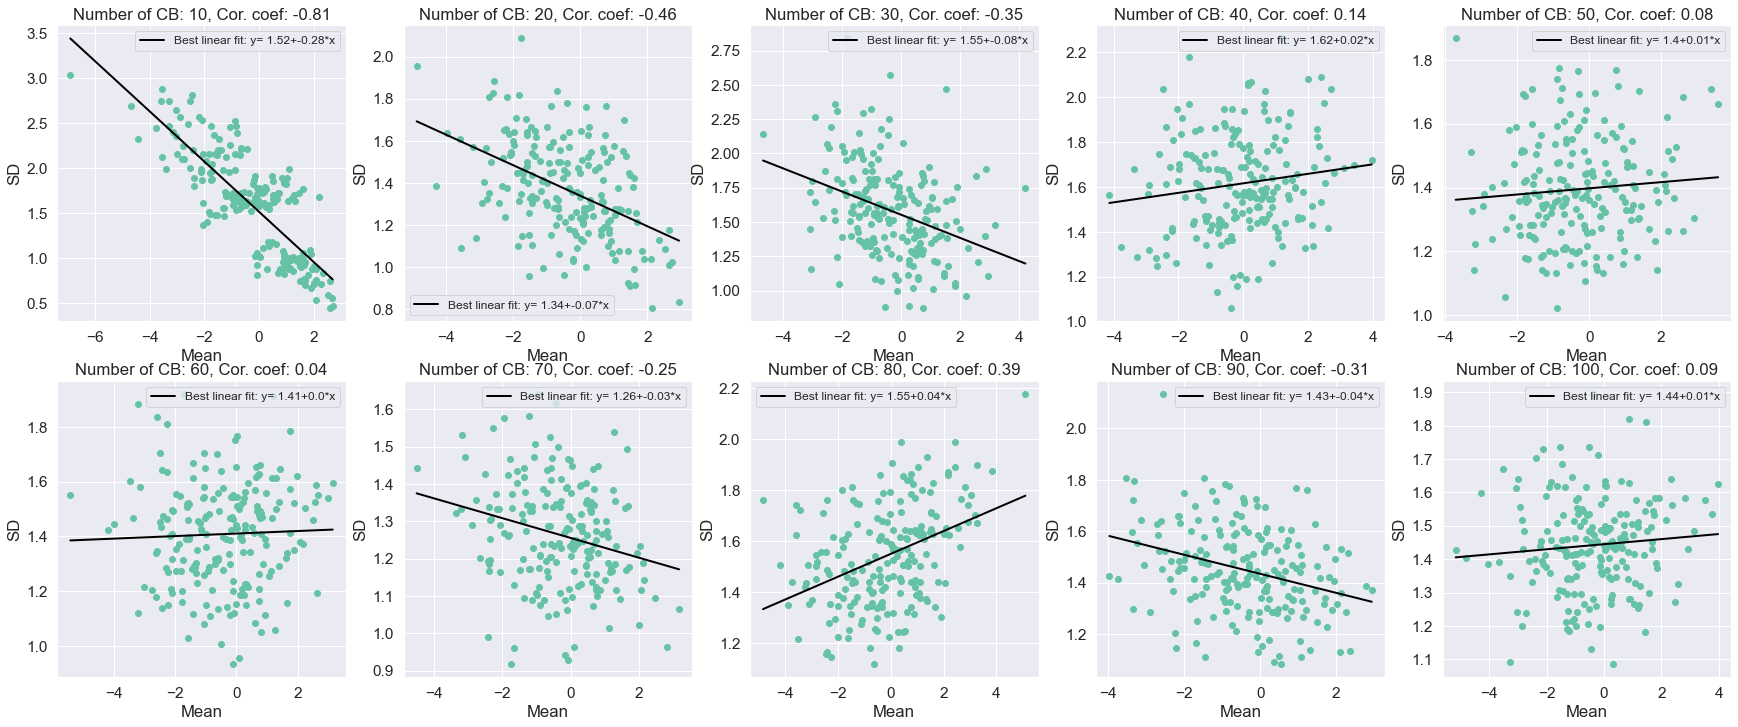

In [179]:
plt.figure(figsize=[30,12])
for i, cur_number_of_buckets in enumerate(cand_num_of_cookie_buckets):
    plt.subplot(2, 5, i+1).set_title('Number of CB: ' + str(cur_number_of_buckets)+', Cor. coef: '+ str(np.corrcoef(boot_jack_est_99[i],boot_jack_stds_99[i])[1,0].round(2)))
    cur_boot_est = np.array(boot_jack_est_99[i])
    cur_boot_stds= np.array(boot_jack_stds_99[i])
    plt.scatter(cur_boot_est,cur_boot_stds)
    reg_1 = LinearRegression().fit(cur_boot_est.reshape(-1,1),cur_boot_stds)
    x_range = np.linspace(min(cur_boot_est), max(cur_boot_est))
    plt.plot(x_range ,reg_1.intercept_ + reg_1.coef_ * x_range, color='black', label='Best linear fit: y= ' + 
    str(reg_1.intercept_.round(2)) +'+' +str(reg_1.coef_.round(2)[0])+"*x")
    plt.legend(prop={'size': 12})
    plt.xlabel('Mean')
    plt.ylabel('SD')


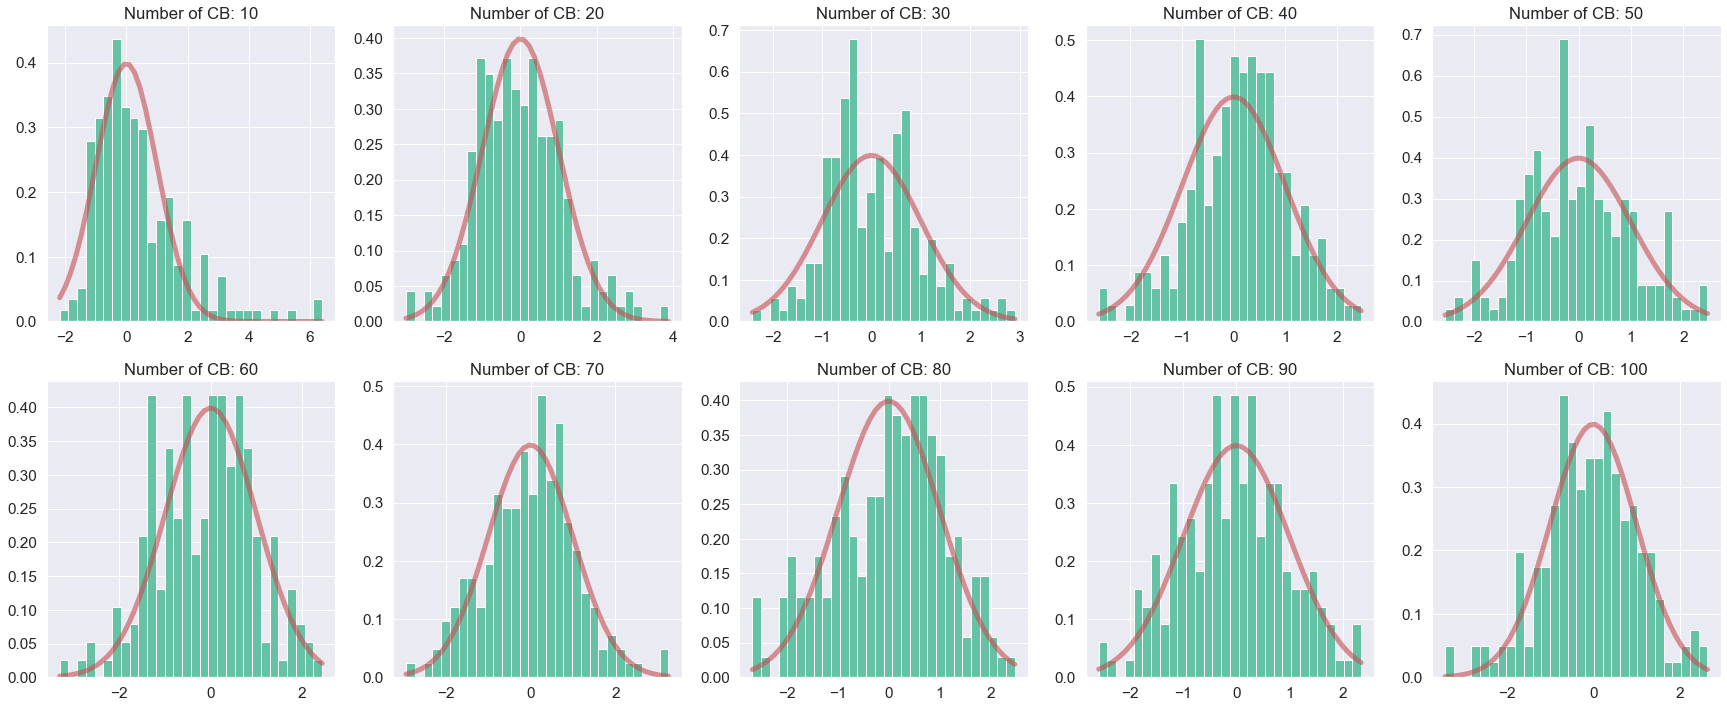

In [180]:
plt.figure(figsize=[30,12])
for i, cur_number_of_buckets in enumerate(cand_num_of_cookie_buckets):
    plt.subplot(2, 5, i+1).set_title('Number of CB: ' + str(cur_number_of_buckets))
    cur_boot_est = np.array(boot_jack_est_99[i])
    cur_boot_stds= np.array(boot_jack_stds_99[i])
    t_stat = (cur_boot_est-orig_jack_est_99[i])/cur_boot_stds
    plt.hist(t_stat, bins=30, density=True)
    
    x_range = np.linspace(min(t_stat), max(t_stat))
    
    plt.plot(x_range, norm.pdf(x_range),
       'r-', lw=5, alpha=0.6, label='norm pdf')
    


## Lognormal

In [181]:
number_of_inner_boot_samples = 200
number_of_outer_boot_samples = 200

In [182]:
raw_data_treatment = generate_raw_data_lognormal(number_of_users = 1000, mean_param=7,sigma_param=1)
raw_data_control = generate_raw_data_lognormal(number_of_users = 1000, mean_param=7,sigma_param=1)

In [183]:
lognormal_orig_jack_est = list()
lognormal_boot_jack_est_50 = list()
lognormal_boot_jack_stds_50 = list()

In [184]:
for cookie_bucket in cand_num_of_cookie_buckets:
    lognormal_boot_jack_est_50 +=[[]]
    lognormal_boot_jack_stds_50 +=[[]]

In [185]:
cur_quantile_of_interest = 0.5

for cur_ind, cur_num_of_cookie_buckets in enumerate(cand_num_of_cookie_buckets):
    # bin raw data and place the clients into cookie buckets
    bucketed_data_treat = get_binned_data_cookie_bucket_level(raw_data_treatment,cur_num_of_cookie_buckets, bins_boundaries).values
    bucketed_data_control = get_binned_data_cookie_bucket_level(raw_data_control,cur_num_of_cookie_buckets, bins_boundaries).values

    lognormal_orig_jack_est +=[np.mean(compute_pseudovals_jackknife(bucketed_data_treat,bucketed_data_control,
        bins_boundaries,cur_quantile_of_interest))]

    # possible indices to perform resamplaing
    indices = np.arange(cur_num_of_cookie_buckets)

    for i in range(number_of_outer_boot_samples):
        ind_resampled = np.random.choice(
                indices, size=cur_num_of_cookie_buckets)

        boot_treat = bucketed_data_treat[ind_resampled, :]
        boot_control = bucketed_data_control[ind_resampled, :]
        #compute pseudo-values
        pseudo_vals = compute_pseudovals_jackknife(boot_treat,boot_control,bins_boundaries,cur_quantile_of_interest)
        # compute the mean / jackknife estimator
        lognormal_boot_jack_est_50[cur_ind] += [np.mean(pseudo_vals)]
        #estimate standard error of this estimator
        inner_est = list()
        for j in range(number_of_inner_boot_samples):
            ind_resampled_inner = np.random.choice(
                indices, size=cur_num_of_cookie_buckets)

            boot_treat_inner = boot_treat[ind_resampled_inner, :]
            boot_control_inner = boot_control[ind_resampled_inner, :]
            cur_psvals =compute_pseudovals_jackknife(boot_treat_inner,boot_control_inner,bins_boundaries,cur_quantile_of_interest) 
            inner_est+=[np.mean(cur_psvals)]
               
        lognormal_boot_jack_stds_50[cur_ind]+=[np.std(inner_est,ddof=1)]

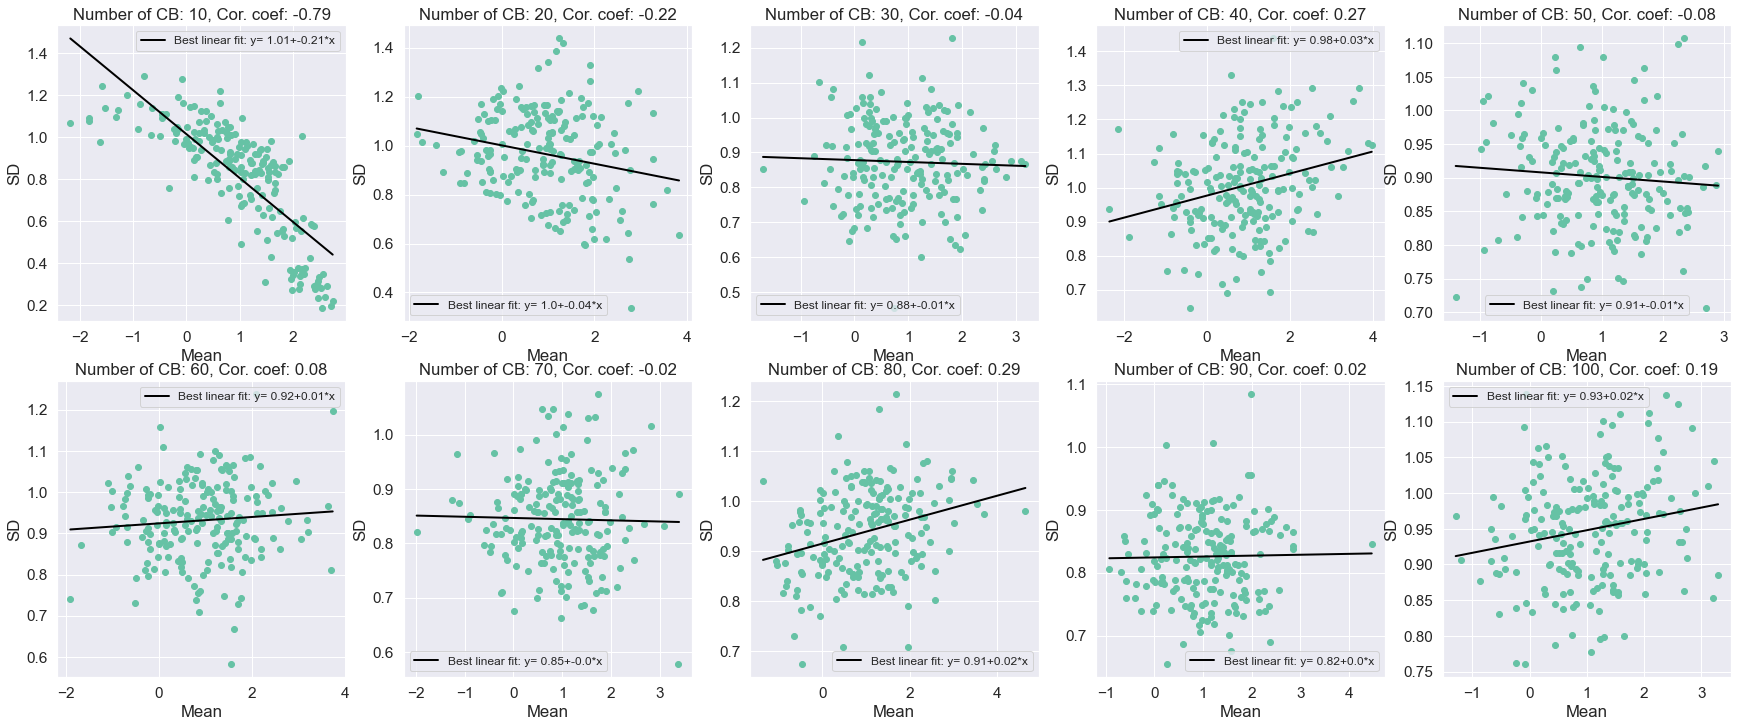

In [186]:
plt.figure(figsize=[30,12])
for i, cur_number_of_buckets in enumerate(cand_num_of_cookie_buckets):
    plt.subplot(2, 5, i+1).set_title('Number of CB: ' + str(cur_number_of_buckets)+', Cor. coef: '+ str(np.corrcoef(lognormal_boot_jack_est_50[i],lognormal_boot_jack_stds_50[i])[1,0].round(2)))
    cur_boot_est = np.array(lognormal_boot_jack_est_50[i])
    cur_boot_stds= np.array(lognormal_boot_jack_stds_50[i])
    plt.scatter(cur_boot_est,cur_boot_stds)
    reg_1 = LinearRegression().fit(cur_boot_est.reshape(-1,1),cur_boot_stds)
    x_range = np.linspace(min(cur_boot_est), max(cur_boot_est))
    plt.plot(x_range ,reg_1.intercept_ + reg_1.coef_ * x_range, color='black', label='Best linear fit: y= ' + 
    str(reg_1.intercept_.round(2)) +'+' +str(reg_1.coef_.round(2)[0])+"*x")
    plt.legend(prop={'size': 12})
    plt.xlabel('Mean')
    plt.ylabel('SD')


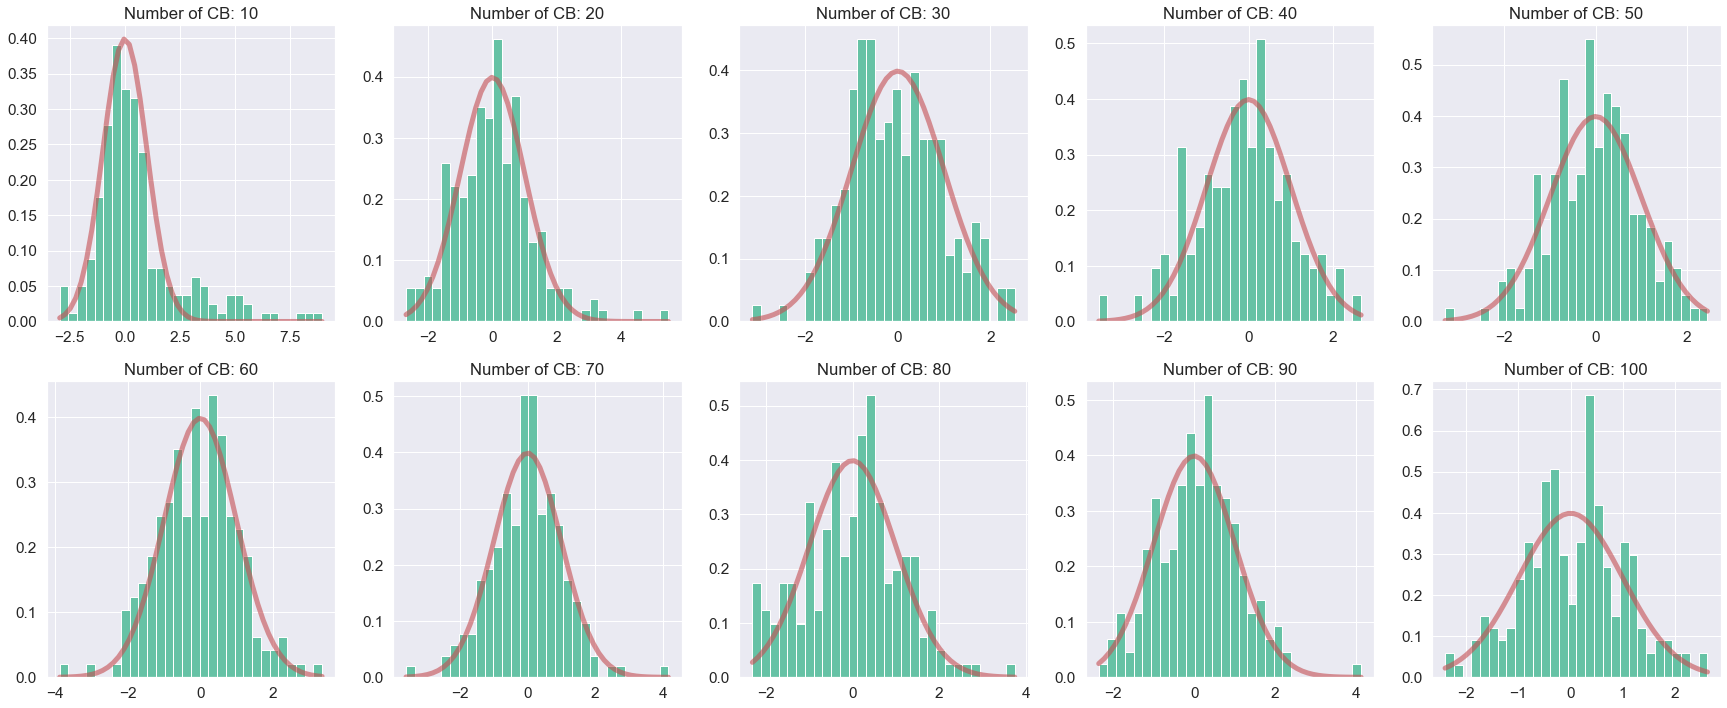

In [189]:
plt.figure(figsize=[30,12])
for i, cur_number_of_buckets in enumerate(cand_num_of_cookie_buckets):
    plt.subplot(2, 5, i+1).set_title('Number of CB: ' + str(cur_number_of_buckets))
    cur_boot_est = np.array(lognormal_boot_jack_est_50[i])
    cur_boot_stds= np.array(lognormal_boot_jack_stds_50[i])
    t_stat = (cur_boot_est-lognormal_orig_jack_est[i])/cur_boot_stds
    plt.hist(t_stat,bins=30, density=True)
    
    
    x_range = np.linspace(min(t_stat), max(t_stat))
    
    plt.plot(x_range, norm.pdf(x_range),
       'r-', lw=5, alpha=0.6, label='norm pdf')
    
